<a href="https://colab.research.google.com/github/s331440/DAVE3625/blob/main/Copy_of_3D_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense , Reshape,Flatten,Conv3D,Conv3DTranspose,LeakyReLU,Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.python import metrics
from tensorflow.keras.metrics import binary_crossentropy,categorical_crossentropy

In [3]:
path = ('/content/drive/MyDrive/modelnet10.npz')

In [5]:
data = np.load(path, allow_pickle=True)
train_voxel = data["train_voxel"] # Training 3D voxel samples
#test_voxel = data["test_voxel"] # Test 3D voxel samples
train_labels = data["train_labels"] # Training labels (integers from 0 to 9)
#test_labels = data["test_labels"] # Test labels (integers from 0 to 9)
class_map = data["class_map"] # Dictionary mapping the labels to their class names.

In [6]:
print(train_voxel.shape)

(3991, 64, 64, 64)


In [7]:
print(class_map)

{0: 'bathtub', 1: 'bed', 2: 'chair', 3: 'desk', 4: 'dresser', 5: 'monitor', 6: 'night_stand', 7: 'sofa', 8: 'table', 9: 'toilet'}


In [8]:
print(np.where(train_labels==9)[0][0])

3647


KeyboardInterrupt: ignored

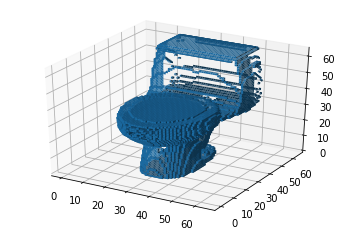

In [9]:
# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(train_voxel[3647]) 
#0 for bathtub, 106 for bed, 621 for chair, 1510 for desk, 1710 for dresser, 1910 for monitor, 
#2375 for night stand, 2575 for sofa, 3255 for table, 3647 for toilet

plt.show()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
opt = Adam(learning_rate=0.0002,beta_1 = 0.5)

In [12]:
def define_discriminator(in_shape=(64,64,64,1)):
  print('inside discriminator')
  model = Sequential()
  model.add(Conv3D(64,(4,4,4), strides=(2,2,2), padding ='same', input_shape = in_shape))
  model.add(LeakyReLU(alpha= 0.00001))
  model.add(BatchNormalization())
  

  model.add(Conv3D(64,(4,4,4), strides=(2,2,2), padding ='same'))
  model.add(LeakyReLU(alpha= 0.00001))
  model.add(BatchNormalization())
  

  model.add(Conv3D(128,(4,4,4), strides=(2,2,2), padding ='same'))
  model.add(LeakyReLU(alpha= 0.00001))
  model.add(BatchNormalization())
  

  model.add(Conv3D(256,(4,4,4), strides=(2,2,2), padding ='same'))
  model.add(LeakyReLU(alpha= 0.00001))
  model.add(BatchNormalization())
  

  model.add(Conv3D(512,(4,4,4), strides=(2,2,2), padding ='same'))
  model.add(LeakyReLU(alpha= 0.00001))
  model.add(BatchNormalization())

  #model.add(Conv3D(512,(4,4,4), strides=(2,2,2), padding ='same'))
  #model.add(LeakyReLU(alpha= 0.00001))
  #model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dropout(0.4))
  ##assert model.output_shape == (None,4096)
  model.add(Dense(64,activation='sigmoid'))
  model.add(Dense(1,activation='sigmoid'))
  #model.add(Reshape(32,32,32))
  model.compile(loss=binary_crossentropy,optimizer=opt, metrics=['accuracy'])
  return model

In [13]:
test_discr = define_discriminator()
print(test_discr.summary())

inside discriminator
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 32, 32, 32, 64)    4160      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32, 64)    0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 16, 16, 64)    262208    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 16, 64)    0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 16, 64)   256       
 hNormalization)                   

In [14]:
def define_generator(latent_dim):
  model = Sequential()
  n_nodes = 200*1*1*1
  #model.add(Dense(n_nodes,input_dim = latent_dim))
  #model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((1,1,1,200)))
  model.add(Conv3DTranspose(512,(4,4,4), strides=(1,1,1),padding='valid'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv3DTranspose(256,(4,4,4), strides=(2,2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv3DTranspose(128,(4,4,4), strides=(2,2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv3DTranspose(128,(4,4,4), strides=(2,2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv3DTranspose(64,(4,4,4), strides=(2,2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Conv3DTranspose(128,(4,4,4), strides=(2,2,2),padding='same'))
  #model.add(BatchNormalization())
  #model.add(LeakyReLU(alpha=0.2))
  model.add(Conv3D(1,(8,8,8),activation = 'sigmoid',padding = 'same'))
  return model


In [27]:
test_gen_1 = define_generator(200)

In [28]:
test_gen_2 = define_generator(200)

In [29]:
test_gen_3 = define_generator(200)

In [30]:
test_gen_4 = define_generator(200)

In [16]:
latent_vector_1 = tf.random.normal([1, 200])

In [17]:
print(latent_vector_1)

tf.Tensor(
[[ 0.2551649   1.0147661  -0.93239427  2.1784866  -0.00658863  0.56970066
  -2.2030516  -0.04364963  0.18253429  1.4960599  -0.44002712 -0.6757945
  -1.0138209  -0.73949254 -0.32460067  1.1754148  -1.2066611  -0.04065163
  -0.9681239  -0.0568855   0.21522182 -0.4533349   0.46828702 -0.6967687
  -0.12846175 -0.41659623  0.08232348  0.24633336  0.31022003 -1.2331916
  -0.77182     1.6862828  -0.5132465  -0.42318425  1.9260873   0.33813703
  -0.23536341 -2.121938   -0.89517355  1.3635464   1.1897887   1.0003155
   1.4173778  -1.2852745  -1.27282     2.1991138  -0.68670005 -1.4043239
   0.822769    0.893432   -0.74010754  0.02104728 -0.9302026   0.86273134
  -0.41840675 -1.0504513   0.12815456  0.4006565  -0.09987405  1.0231643
   1.2511182  -1.0166299   0.10053904 -1.7924793  -0.4098189   0.14671756
   0.02922473  0.03885923 -0.9912108   1.1398841  -0.4746112  -0.08210599
   0.54259807  0.53869027  0.02638216 -0.08094239  0.68276554  0.6965385
  -0.75347173 -0.65590894  0.25363

In [18]:
latent_vector_2 = tf.random.normal([1, 200])

In [19]:
print(latent_vector_2)

tf.Tensor(
[[-2.1244216  -0.6758971   0.59992856  0.36136368  2.439374   -0.5635107
   0.6278336  -0.1692958   0.7401008  -0.60702986 -0.00746204  0.5112259
  -2.4236946  -0.4561084   0.4985338   0.27665865 -0.8148809   0.6367687
   0.22274067 -0.77191824  1.1023923  -1.0291504  -0.37836462 -0.89904267
  -1.3151453  -0.9976397  -1.2443322   0.1840747   1.009217    0.1426692
  -2.163831   -0.54077184 -0.7925071   2.7289062   0.9327382   1.1427187
  -0.7849775   3.0450227   0.2454387  -0.8034579   0.01748104 -1.0305324
   1.6264836   1.19139    -1.1811574  -0.86927754  0.9323727  -0.9421703
   0.3509218  -0.40733927  1.2304159   0.9337203   1.480019    1.4999243
   0.83919495 -1.6045862  -2.221324   -0.5517327  -2.2429702  -0.07708899
   0.9381197   0.39361304  0.2849645  -0.5194961   0.656938    0.9921771
   0.24321379 -1.9397693  -2.9006724   0.13120912 -0.13410166  0.41968986
  -0.00844794  0.854088   -0.32428572  0.6051122  -0.8337575  -0.79373765
   0.70996845  0.28748745  0.4439165

In [20]:
latent_vector_3 = tf.random.normal([1, 200])

In [21]:
print(latent_vector_3)

tf.Tensor(
[[ 7.81635847e-03 -4.56873804e-01  5.33292532e-01 -1.69545019e+00
   1.12043428e+00 -1.12683749e+00 -6.25428319e-01  3.29120278e-01
  -1.11192071e+00 -2.24897933e+00 -7.22581208e-01  3.50731826e+00
  -1.61109424e+00  1.36463225e+00  1.23724446e-01 -1.70686185e+00
  -8.21553588e-01 -1.12779164e+00  1.67973268e+00  8.99224281e-01
  -1.25894213e+00 -5.09398222e-01 -1.50750554e+00 -1.11945665e+00
   1.00238180e+00 -2.54752368e-01 -1.92461562e+00 -1.12220056e-01
  -2.61526316e-01  3.08134019e-01 -9.82094228e-01 -7.21758068e-01
  -1.07244515e+00  1.08636558e+00  5.90108216e-01 -8.03992629e-01
   7.79426843e-02 -2.03763973e-02  3.03710322e-03 -9.92354751e-01
   1.07043350e+00 -6.39021575e-01  7.13054240e-02 -1.97189450e+00
   2.09592223e+00  7.36951411e-01  1.87855434e+00 -1.79349113e+00
   9.86900568e-01 -6.35659695e-02  6.71430767e-01 -3.37148249e-01
  -8.40458572e-01  3.47189873e-01  2.95096397e-01 -5.29355481e-02
   5.30594468e-01  1.76594496e+00 -1.47379804e+00  5.43535769e-01

In [22]:
latent_vector_4 = tf.random.normal([1, 200])

In [23]:
print(latent_vector_4)

tf.Tensor(
[[-2.23934576e-01 -2.08075213e+00 -3.18474382e-01  2.99737245e-01
   8.46739650e-01  3.73916477e-01  3.30855346e+00  4.60018277e-01
  -1.57875443e+00 -1.50555611e+00 -6.15934432e-01  5.91189682e-01
  -3.83460402e+00 -9.90693331e-01 -6.11166835e-01  2.58263320e-01
  -2.31389642e+00 -1.16880798e+00  5.89842975e-01 -7.76112080e-01
  -1.42005265e+00  4.00170416e-01 -1.08452570e+00  2.75583953e-01
  -4.97794077e-02 -1.27741173e-01  4.68620747e-01  3.28376561e-01
   2.99344093e-01  7.09684014e-01  7.82042205e-01  4.70177144e-01
  -2.11865813e-01 -2.34800987e-02 -9.99092817e-01  6.24330461e-01
   1.13794434e+00 -6.36402488e-01  1.89839518e+00 -1.12488043e+00
   9.71898288e-02 -3.96320850e-01 -3.06860447e-01 -6.62786722e-01
   9.64225054e-01  6.04750276e-01 -4.28666294e-01  1.41145527e+00
  -1.30435038e+00 -4.94985282e-01  4.47763413e-01  6.80855632e-01
   5.93339503e-01  7.06746221e-01  2.88224435e+00 -1.65503359e+00
   2.69414783e-01 -1.53806269e+00 -2.63275456e+00 -1.55485302e-01

In [32]:
noise = tf.random.normal([1, 200])
latent_vector_1 = test_gen_1(noise, training=False)

In [33]:
noise = tf.random.normal([1, 200])
latent_vector_2 = test_gen_2(noise, training=False)

In [34]:
noise = tf.random.normal([1, 200])
latent_vector_3 = test_gen_3(noise, training=False)

In [35]:
noise = tf.random.normal([1, 200])
latent_vector_4 = test_gen_4(noise, training=False)

In [25]:
print(test_gen_1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (1, 1, 1, 1, 200)         0         
                                                                 
 conv3d_transpose (Conv3DTra  (1, 4, 4, 4, 512)        6554112   
 nspose)                                                         
                                                                 
 batch_normalization_5 (Batc  (1, 4, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (1, 4, 4, 4, 512)         0         
                                                                 
 conv3d_transpose_1 (Conv3DT  (1, 8, 8, 8, 256)        8388864   
 ranspose)                                                       
                                                      

In [36]:
print(test_gen_2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (1, 1, 1, 1, 200)         0         
                                                                 
 conv3d_transpose_10 (Conv3D  (1, 4, 4, 4, 512)        6554112   
 Transpose)                                                      
                                                                 
 batch_normalization_15 (Bat  (1, 4, 4, 4, 512)        2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (1, 4, 4, 4, 512)         0         
                                                                 
 conv3d_transpose_11 (Conv3D  (1, 8, 8, 8, 256)        8388864   
 Transpose)                                                      
                                                      

In [37]:
print(test_gen_3.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (1, 1, 1, 1, 200)         0         
                                                                 
 conv3d_transpose_15 (Conv3D  (1, 4, 4, 4, 512)        6554112   
 Transpose)                                                      
                                                                 
 batch_normalization_20 (Bat  (1, 4, 4, 4, 512)        2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (1, 4, 4, 4, 512)         0         
                                                                 
 conv3d_transpose_16 (Conv3D  (1, 8, 8, 8, 256)        8388864   
 Transpose)                                                      
                                                      

In [38]:
print(test_gen_4.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (1, 1, 1, 1, 200)         0         
                                                                 
 conv3d_transpose_20 (Conv3D  (1, 4, 4, 4, 512)        6554112   
 Transpose)                                                      
                                                                 
 batch_normalization_25 (Bat  (1, 4, 4, 4, 512)        2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (1, 4, 4, 4, 512)         0         
                                                                 
 conv3d_transpose_21 (Conv3D  (1, 8, 8, 8, 256)        8388864   
 Transpose)                                                      
                                                      

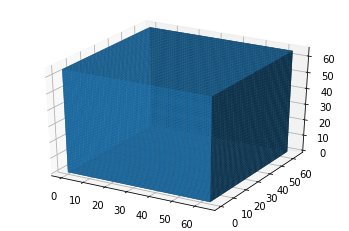

In [39]:
# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(latent_vector_1[0,:,:,:,0])

plt.show()

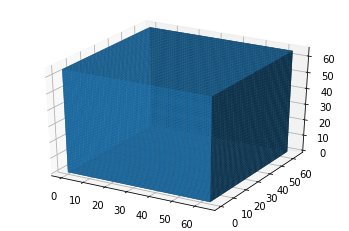

In [40]:
# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(latent_vector_2[0,:,:,:,0])

plt.show()

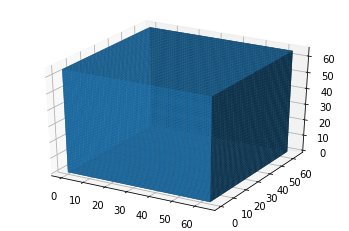

In [43]:
# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(latent_vector_3[0,:,:,:,0])

plt.show()

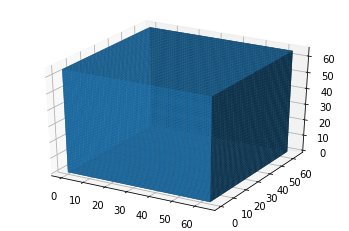

In [44]:
# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(latent_vector_4[0,:,:,:,0])

plt.show()

In [42]:
import os.path
latent_vector_1.save('/content/drive/MyDrive/latent_vector_1.h5')

AttributeError: ignored

In [47]:
savefig(latent_vector_1, * dpi='figure', format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None, **kwargs
       )

SyntaxError: ignored

In [ ]:
from tensorflow.keras.models import load_model
temp = load_model('/content/drive/MyDrive/latent_vector_1.h5')

In [49]:
def generate_latent_points(latent_dim,n_samples):
  X_input = np.random.randn(latent_dim * n_samples)
  X_input = X_input.reshape(n_samples,latent_dim)
  return X_input  

In [50]:
def define_gan(generator,discriminator):
  discriminator.trainable = False
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  opt = Adam(learning_rate = 0.0025,beta_1 = 0.5)
  model.compile(loss='binary_crossentropy',optimizer = opt)
  return model

In [51]:
def get_real_samples(train_voxel,n_samples):
  #choose random images
  ix = np.random.randint(0,train_voxel.shape[0],n_samples)
  X = train_voxel[ix]
  #assigning 1 to y indicating real images
  y = np.ones((n_samples,1))
  return X,y

In [52]:
def generate_fake_Samples(generator,latent_dim,n_samples):
  #generate points in latent space
  x_input = generate_latent_points(latent_dim,n_samples)
  #predict using generator to generate fake samples
  X = generator.predict(x_input)
  # labeled as 0 since they are fake samples
  y = np.zeros((n_samples,1))
  return X,y


In [53]:
def train(g_model, d_model,gan_model,train_voxel,latent_dim,n_epochs = 3, n_batch= 10):
  bat_per_epo = int(train_voxel.shape[0] / n_batch)
  half_batch = int(n_batch / 2)

  #training loop
  for i in range(n_epochs):
    for j in range(n_batch):
      
      X_real,y_real = get_real_samples(train_voxel,half_batch)
      #measuring loss of discriminator
      d_loss_real,_ = d_model.train_on_batch(X_real,y_real) 

      #generate fake samples
      X_fake,y_fake = generate_fake_Samples(g_model,latent_dim,half_batch)
      d_loss_fake,_ = d_model.train_on_batch(X_fake,y_fake)

      #prepare latent points as input to the generator
      X_gan = generate_latent_points(latent_dim,n_batch)

      #generated samples are labeled as valid to fool the discriminator
      y_gan = np.ones((n_batch,1))

      #train generator with latent_dim and y as 1
      g_loss = gan_model.train_on_batch(X_gan,y_gan)

      print('Epoch>%d, Batch %d/%d,d1=%.3f,d2=%.3f,g=%.3f' %
            (i+1,j+1,bat_per_epo,d_loss_real,d_loss_fake,g_loss))

In [54]:
#train the gan
#size of latent space
latent_dim = 200
#create the discriminator
discriminator = define_discriminator()
#create the generator
generator = define_generator(latent_dim)
#create gan
gan_model = define_gan(generator,discriminator)
#train model
train(generator,discriminator,gan_model,train_voxel,latent_dim,n_epochs=3)

inside discriminator
1/1 [==============================] - 7s 7s/step
Epoch>1, Batch 1/399,d1=0.618,d2=0.373,g=0.601
1/1 [==============================] - 0s 121ms/step
Epoch>1, Batch 2/399,d1=0.099,d2=0.804,g=0.608
1/1 [==============================] - 0s 124ms/step
Epoch>1, Batch 3/399,d1=0.031,d2=0.010,g=0.615
1/1 [==============================] - 0s 126ms/step
Epoch>1, Batch 4/399,d1=0.096,d2=0.010,g=0.621
1/1 [==============================] - 0s 121ms/step
Epoch>1, Batch 5/399,d1=0.077,d2=0.012,g=0.623
1/1 [==============================] - 0s 125ms/step
Epoch>1, Batch 6/399,d1=0.018,d2=0.015,g=0.631
1/1 [==============================] - 0s 122ms/step
Epoch>1, Batch 7/399,d1=0.734,d2=0.012,g=0.571
1/1 [==============================] - 0s 124ms/step
Epoch>1, Batch 8/399,d1=0.028,d2=0.021,g=0.550
1/1 [==============================] - 0s 123ms/step
Epoch>1, Batch 9/399,d1=0.015,d2=0.012,g=0.541
1/1 [==============================] - 0s 119ms/step
Epoch>1, Batch 10/399,d1=0.02

In [55]:
import os.path
discriminator.save('/content/drive/MyDrive/3D-discriminator.h5')

In [56]:
generator.save('/content/drive/MyDrive/3D-generator.h5')

In [ ]:
from tensorflow.keras.models import load_model
temp = load_model('/content/drive/MyDrive/3D-discriminator.h5')

In [ ]:
temp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 32, 32, 32, 64)    4160      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 32, 64)    0         
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 32, 64)   256       
 chNormalization)                                                
                                                                 
 conv3d_7 (Conv3D)           (None, 16, 16, 16, 64)    262208    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 16, 64)    0         
                                                                 
 batch_normalization_11 (Bat  (None, 16, 16, 16, 64)   256       
 chNormalization)                                     

In [ ]:
temp.get_weights()

[array([[[[[ 0.02973249, -0.02428104, -0.00563762, ..., -0.0061293 ,
             0.00535445,  0.00426235]],
 
          [[ 0.03573967, -0.0251929 ,  0.02339801, ..., -0.03023327,
             0.00088611, -0.01567175]],
 
          [[-0.02133663, -0.01628113, -0.03523232, ...,  0.02051859,
            -0.01498069,  0.02718337]],
 
          [[ 0.02477707,  0.0370237 , -0.03304525, ..., -0.0138527 ,
             0.0006745 ,  0.00340398]]],
 
 
         [[[ 0.03151697, -0.0285752 , -0.02813411, ..., -0.00342555,
            -0.01539693,  0.03048783]],
 
          [[-0.0025467 , -0.02382137, -0.02759149, ...,  0.02039839,
            -0.02447692,  0.01184137]],
 
          [[ 0.0106052 , -0.02046806,  0.03803729, ...,  0.02229671,
            -0.00088959,  0.01811094]],
 
          [[-0.02558239,  0.02252311,  0.01167903, ..., -0.0314067 ,
            -0.02738345, -0.02910757]]],
 
 
         [[[-0.00294934,  0.03720225, -0.01992152, ...,  0.0193618 ,
            -0.01622767,  0.02208835]

In [ ]:
temp.optimizer

In [ ]:
layers = temp.layers
print(layers[0])
#filters,biases = layers_classifier[1].get_weights()
#print(layers_classifier[1],filters.shape)

In [ ]:
from tensorflow.keras.layers import MaxPooling3D
opt = Adam(learning_rate=0.0002,beta_1 = 0.5)

In [ ]:
def define_classifier(layers):

  conv1 = layers[5].output
  out1 = tf.keras.layers.MaxPool3D(pool_size=(8,8,8))(conv1)
  conv2 = layers[8].output
  out2 = tf.keras.layers.MaxPool3D(pool_size=(4,4,4))(conv2)
  conv3 = layers[11].output
  out3 = tf.keras.layers.MaxPool3D(pool_size=(2,2,2))(conv3)
  conc = tf.keras.layers.Concatenate()([out1,out2,out3])
  flat = tf.keras.layers.Flatten()(conc)
  output = tf.keras.layers.Dense(10,activation='softmax')(flat)
  model = tf.keras.Model(inputs = conv1,outputs = output)
  model.compile(loss=categorical_crossentropy,optimizer=opt, metrics=['accuracy'])
  return model




In [ ]:
classifier = define_classifier(layers)
print(classifier.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 16, 16,  0           []                               
                                 64)]                                                             
                                                                                                  
 conv3d_8 (Conv3D)              (None, 8, 8, 8, 128  524416      ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_12 (LeakyReLU)     (None, 8, 8, 8, 128  0           ['conv3d_8[1][0]']               
                                )                                                             

In [ ]:
def train_classifier(classifier,train_voxel,num_epochs=2,num_batch=10):
  for i in range(num_epochs):
    for j in range(num_batch):
      C_loss,_ = classifier.train_on_batch(train_voxel)
      print('Epoch>%d, Batch %d/%d,d1=%.3f' %
            (i+1,j+1,C_loss))


In [ ]:
def resize_images(train_voxel):

  #a = tf.ones(shape=[1,64,64,64,1])
  #a.shape

  a2 = tf.reshape(train_voxel,[-1,64,64,64*1])
  a2.shape

  a3 = tf.image.resize(a2,[16,16])
  a3.shape

  a4 = tf.reshape(a3,[-1,16,16,64,1])
  a4.shape

  transposed = tf.transpose(a4,[0,1,3,2,4])
  transposed.shape

  a5 = tf.reshape(transposed,[1*16,64,16,1])
  a5.shape

  new_size = tf.constant([16,16])
  resized = tf.image.resize(a5,new_size)
  resized.shape

#undo transpose 
  undo_reshape = tf.reshape(resized,[1,16,16,16,1])
  undo_transpose = tf.transpose(undo_reshape,[0,2,3,1,4])
  undo_transpose.shape

In [ ]:
new_var = np.zeros((16, 16, 16))

In [ ]:
for i in range(3991):
  a2 = tf.reshape(train_voxel[i],[-1,64,64,64*1])
  a3 = tf.image.resize(a2,[16,16])
  a4 = tf.reshape(a3,[-1,16,16,64,1])
  transposed = tf.transpose(a4,[0,1,3,2,4])
  a5 = tf.reshape(transposed,[1*16,64,16,1])
  new_size = tf.constant([16,16])
  resized = tf.image.resize(a5,new_size)
  undo_reshape = tf.reshape(resized,[1,16,16,16,1])
  undo_transpose = tf.transpose(undo_reshape,[0,2,3,1,4])
  new_var[i] = undo_transpose
new_var[0].shape

ValueError: ignored

In [ ]:
train_classifier(classifier,train_voxel,num_epochs=2,num_batch=10)

ValueError: ignored